# Exporting LLM Runs and Feedback


#### Setup

First, install langsmith and pandas and set your langsmith API key to connect to your project.
We will also install LangChain to use one of its formatting utilities.

In [26]:
# %pip install --upgrade --force-reinstall langchain langsmith pandas seaborn --quiet
import os  # Add this line at the beginning of your code

In [27]:
%env LANGCHAIN_API_KEY='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'
# %pip install --upgrade pandas

env: LANGCHAIN_API_KEY='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'


In [28]:
from langsmith import Client
import pandas as pd

client = Client()

stamp = "3683"
batches = [
    {"name": "sketch_generator", "batch_id": f"{stamp}_sg_batch"},
    {"name": "sketch_generator_dejson", "batch_id": f"{stamp}_sg_dejson_batch"},
    {"name": "sketch_generator_dejson2", "batch_id": f"{stamp}_sg_dejson2_batch"},
]
current_batch = batches[0]

# sg_batch = {"name": "sketch_generator", "batch_id": "7058_batch"}

## 1. Query Runs
 query and save to json files
 


In [29]:
from datetime import datetime, timedelta
from datetime import timezone
import json

# batch_tests 10.28:
#   data_processor: batch_id: 2117_batch
#   model_converter: batch_id: 7121_batch
#   sketch_generator: batch_id: 1730_batch

#   sketch_generato2: batch_id: 2172_batch


def run_to_dict(run):
    return {
        "id": str(run.id),
        "name": run.name,
        "timing": {
            "start_time": run.start_time.strftime("%Y-%m-%d %H:%M:%S.%f"),
            "end_time": run.end_time.strftime("%Y-%m-%d %H:%M:%S.%f"),
        },
        "run_type": run.run_type,
        "metadata": {
            "trace_id": run.extra.get("metadata", {}).get("trace_id"),
            "num_run": run.extra.get("metadata", {}).get("num_run"),
            "batch_id": run.extra.get("metadata", {}).get("batch_id"),
            "network_latency": run.extra.get("metadata", {}).get("network_latency"),
            "ls_method": run.extra.get("metadata", {}).get("ls_method"),
            "revision_id": run.extra.get("metadata", {}).get("revision_id"),
        },
        "runtime": run.extra.get("runtime", {}),
        "tokens": {
            "prompt_tokens": run.prompt_tokens,
            "completion_tokens": run.completion_tokens,
            "total_tokens": run.total_tokens,
        },
        "cost": {
            "prompt_cost": float(run.prompt_cost) if run.prompt_cost else None,
            "completion_cost": (
                float(run.completion_cost) if run.completion_cost else None
            ),
            "total_cost": float(run.total_cost) if run.total_cost else None,
        },
        "status": run.status,
        "session_id": str(run.session_id) if run.session_id else None,
        "child_run_ids": (
            [str(run_id) for run_id in run.child_run_ids] if run.child_run_ids else []
        ),
        "tags": run.tags,
    }


def save_runs(current_batch):
    runs = list(
        client.list_runs(
            project_name="default",
            start_time=datetime.now(timezone.utc) - timedelta(days=2),
            run_type="llm",
            # filter=f'and(has(tags, \'gpt-4o-mini\'),has(tags, {task_type}))',
            filter=f"and(eq(metadata_key, 'batch_id'), eq(metadata_value, '{current_batch['batch_id']}'))",
        )
    )

    output_dir = "raw_export"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    output_file = (
        f"{output_dir}/js_{current_batch['name']}_{current_batch['batch_id']}.json"
    )

    # Convert list of Run objects to list of dicts
    runs_data = [run_to_dict(run) for run in runs]

    # Write to JSON file
    try:
        with open(output_file, "w", encoding="utf-8") as f:
            json.dump(runs_data, f, indent=2)
        print(f"File successfully created: {output_file}")
    except Exception as e:
        print(f"Failed to create file: {e}")


# for batch in batches:
#     print(batch["batch_id"])
#     save_runs(batch)

## Read data from saved json files, process the data, and create dfs


In [30]:
import pandas as pd
import json

# current_batch = batches[0]


# Open json file
def load_runs_df(json_path):
    """!
    Load and process run data from a JSON file into a pandas DataFrame.

    This function reads a JSON file containing run data, flattens nested structures,
    and converts the data into a pandas DataFrame. It extracts various fields such as
    metadata, runtime information, token counts, and costs, and converts lists to strings
    for certain fields.

    Parameters:
    ----------
    json_path : str
        The file path to the JSON file containing the run data.

    Returns:
    -------
    pd.DataFrame
        A pandas DataFrame containing the processed run data with columns for
        run ID, name, timing, metadata, runtime, tokens, costs, status, session ID,
        child run IDs, and tags. The 'start_time' and 'end_time' columns are converted
        to datetime objects.

    Example:
    -------
    >>> df = load_runs_df("path/to/json_file.json")
    >>> print(df.head())
    """

    # Read JSON file
    with open(json_path, "r") as f:
        data = json.load(f)

    # Flatten nested structures into a list of dictionaries
    flattened_data = []
    for run in data:
        flat_run = {
            "id": run["id"],
            "name": run["name"],
            "start_time": run["timing"]["start_time"],
            "end_time": run["timing"]["end_time"],
            "run_type": run["run_type"],
            # Metadata
            "trace_id": run["metadata"]["trace_id"],
            "num_run": run["metadata"]["num_run"],
            "batch_id": run["metadata"]["batch_id"],
            "network_latency": run["metadata"]["network_latency"],
            # Runtime
            "sdk_version": run["runtime"]["sdk_version"],
            "platform": run["runtime"]["platform"],
            "python_version": run["runtime"]["runtime_version"],
            "langchain_version": run["runtime"]["langchain_version"],
            # Tokens
            "prompt_tokens": run["tokens"]["prompt_tokens"],
            "completion_tokens": run["tokens"]["completion_tokens"],
            "total_tokens": run["tokens"]["total_tokens"],
            # Cost
            "prompt_cost": run["cost"]["prompt_cost"],
            "completion_cost": run["cost"]["completion_cost"],
            "total_cost": run["cost"]["total_cost"],
            "status": run["status"],
            "session_id": run["session_id"],
            "child_run_ids": ",".join(run["child_run_ids"]),  # Convert list to string
            "tags": ",".join(run["tags"]),  # Convert list to string
        }
        flattened_data.append(flat_run)

    # Create a DataFrame from the flattened data
    df = pd.DataFrame(flattened_data)

    # Convert timestamp strings to datetime
    df["start_time"] = pd.to_datetime(df["start_time"])
    df["end_time"] = pd.to_datetime(df["end_time"])

    # Check that end_time is later than start_time
    if not all(df["end_time"] > df["start_time"]):
        raise ValueError("End time must be later than start time for all entries.")

    return df


def initial_process(current_batch):
    """!
    Process the run data for a given batch by loading it from a JSON file,
    cleaning, and preparing it for analysis.

    This function loads run data from a specified JSON file, drops unnecessary
    columns, removes specific rows based on conditions, calculates latency,
    and sorts the data by the 'num_run' column.

    Parameters:
    ----------
    current_batch : dict
        A dictionary containing the 'name' and 'batch_id' of the current batch
        to process.

    Returns:
    -------
    pd.DataFrame
        A pandas DataFrame containing the processed run data with columns for
        run ID, name, timing, metadata, tokens, costs, status, and tags. The
        'latency' column is added, and the DataFrame is sorted by 'num_run'.

    Example:
    -------
    >>> df = initial_process(current_batch)
    >>> print(df.head())
    """
    # Usage: Load the runs data from the specified JSON file
    json_path = (
        f"raw_export/js_{current_batch['name']}_{current_batch['batch_id']}.json"
    )
    df = load_runs_df(json_path)

    # List of columns to drop
    columns_to_drop = [
        "session_id",
        "child_run_ids",
        "sdk_version",
        # "start_time",
        # "end_time",
        "platform",
        "python_version",
        "langchain_version",
        "run_type",
    ]

    # Drop the columns
    for col in columns_to_drop:
        if col in df.columns:
            df = df.drop(columns=[col])

    # Remove rows where the 'name' is 'ChatOpenAI' or ends with 'task_stack'
    df.drop(df[df["name"] == "ChatOpenAI"].index, inplace=True)

    df.drop(df[df["name"].str.endswith("task_stack")].index, inplace=True)

    # Reset the index of the DataFrame after dropping rows
    df.reset_index(drop=True, inplace=True)

    # Add a new column 'latency' calculated as the difference between end and start times in seconds

    df["latency"] = (df["end_time"] - df["start_time"]).dt.total_seconds()

    if any(df["latency"] < 0):
        raise ValueError("Latency cannot be negative for any entry.")

    # Sort DataFrame by num_run
    df = df.sort_values("num_run")

    # Reset index after sorting
    df = df.reset_index(drop=True)

    return df


def print_stats(df):
    """!
    Print various statistics and information about the processed run data.

    This function outputs statistics of the 'latency' column, the range of
    'num_run' values, the remaining columns in the DataFrame, and general
    information about the DataFrame, including data types and non-null counts.

    Parameters:
    ----------
    df : pd.DataFrame
        A pandas DataFrame containing the processed run data.

    Example:
    -------
    >>> print_stats(df)
    """
    # Print statistics of the latency column
    print("\nLatency statistics (in seconds):")
    print(df["latency"].describe())

    # Optional: Display full range of num_run
    print("\nRange of num_run values:")
    print(f"Min: {df['num_run'].min()}, Max: {df['num_run'].max()}")

    # Print sample rows showing name, start time, end time, and latency
    # print("\nSample rows with latency:")
    # print(df[["name", "start_time", "end_time", "latency"]].head())

    print("Remaining columns:")
    print(df.columns.tolist())

    # Print information about the DataFrame, including data types and non-null counts
    print("\nDataFrame Info:")
    print(df.info())

    # Print the first few rows of the DataFrame for initial inspection
    print(df.head())


df = initial_process(current_batch)
print_stats(df)


Latency statistics (in seconds):
count    130.000000
mean      13.449186
std       10.193674
min        0.000470
25%        8.627968
50%       11.920491
75%       16.002943
max       59.502963
Name: latency, dtype: float64

Range of num_run values:
Min: 0, Max: 19
Remaining columns:
['id', 'name', 'start_time', 'end_time', 'trace_id', 'num_run', 'batch_id', 'network_latency', 'prompt_tokens', 'completion_tokens', 'total_tokens', 'prompt_cost', 'completion_cost', 'total_cost', 'status', 'tags', 'latency']

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 130 non-null    object        
 1   name               130 non-null    object        
 2   start_time         130 non-null    datetime64[ns]
 3   end_time           130 non-null    datetime64[ns]
 4   trace_id           130 non-null 

## Drop the columns that are not needed




## Sort the dataframe by num_run


## Combine the subtasks into one task (based on the shared trace_id)

In [31]:
import pandas as pd
import numpy as np


def aggregate_runs(df):
    # 1. Process names - take first 2 sections
    df["name"] = df["name"].apply(lambda x: "_".join(x.split("_")[:2]))

    # Check name consistency within trace_id groups
    name_consistency = df.groupby("trace_id")["name"].nunique()
    if not all(name_consistency == 1):
        print("Warning: Inconsistent names found within trace_id groups:")
        print(name_consistency[name_consistency > 1])

    # 2. Remove id column
    df = df.drop(columns=["id"])

    # Check consistency of num_run, batch_id, tags within trace_id groups
    for col in ["num_run", "batch_id", "tags"]:
        consistency = df.groupby("trace_id")[col].nunique()
        if not all(consistency == 1):
            print(f"Warning: Inconsistent {col} found within trace_id groups:")
            print(consistency[consistency > 1])

    # Columns to aggregate
    sum_columns = [
        "latency",
        "network_latency",
        "prompt_tokens",
        "completion_tokens",
        "total_tokens",
        "prompt_cost",
        "completion_cost",
        "total_cost",
    ]

    def aggregate_status(x):
        if "error" in x.values:
            return "error"
        return "success" if all(x == "success") else "error"

    # Aggregate by trace_id
    agg_dict = {
        "name": "first",
        "num_run": "first",
        "batch_id": "first",
        "tags": "first",
        "status": aggregate_status,
        "start_time": "first",
    }

    # Add sum aggregation for numeric columns
    for col in sum_columns:
        agg_dict[col] = lambda x: x[x.notna()].sum()

    # Perform groupby and aggregation
    df_combined = df.groupby("trace_id").agg(agg_dict).reset_index()

    # 7. Reorder columns
    column_order = [
        "num_run",
        "name",
        "trace_id",
        "latency",
        "network_latency",
        "total_tokens",
        "total_cost",
        "status",
        "batch_id",
        "tags",
        "prompt_tokens",
        "completion_tokens",
        "prompt_cost",
        "completion_cost",
        "start_time",
    ]
    df_combined = df_combined[column_order]

    # 8. Sort by num_run
    df_combined = df_combined.sort_values("num_run")

    return df_combined


# Apply the processing
df_aggregdated = aggregate_runs(df)

# Display results
print("\nProcessed DataFrame Info:")
print(df_aggregdated.info())
print("\nFirst few rows:")
print(df_aggregdated.head())

# Additional verification
print("\nUnique names per trace_id after processing:")
print(df_aggregdated.groupby("trace_id")["name"].nunique().value_counts())


Processed DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 11 to 12
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   num_run            20 non-null     int64         
 1   name               20 non-null     object        
 2   trace_id           20 non-null     object        
 3   latency            20 non-null     float64       
 4   network_latency    20 non-null     float64       
 5   total_tokens       20 non-null     int64         
 6   total_cost         20 non-null     float64       
 7   status             20 non-null     object        
 8   batch_id           20 non-null     object        
 9   tags               20 non-null     object        
 10  prompt_tokens      20 non-null     int64         
 11  completion_tokens  20 non-null     int64         
 12  prompt_cost        20 non-null     float64       
 13  completion_cost    20 non-null     float64  

## Calculate clean latency


In [32]:
def clean_latency(df):
    """
    Adjust the latency in the DataFrame by subtracting twice the network latency,
    validate for any negative latency values, and reorder the DataFrame columns.

    This function modifies the 'latency' column by subtracting twice the value of
    'network_latency' from it. It then checks for any negative latency values, which
    might indicate issues, and prints a warning if any are found. The function also
    removes the 'network_latency' column and reorders the remaining columns in the
    DataFrame.

    Parameters:
    ----------
    df : pd.DataFrame
        A pandas DataFrame containing the processed run data with columns for
        latency and network latency.

    Returns:
    -------
    pd.DataFrame
        A pandas DataFrame with adjusted latency, without the 'network_latency'
        column, and with columns reordered.

    Example:
    -------
    >>> df_processed = clean_latency(df_processed)
    >>> print(df_processed.head())
    """
    # Adjust latency by subtracting twice the network latency
    # df["latency"] = df["latency"] - df["network_latency"]

    # Show results
    print("\nAfter calculation:")
    print(df[["latency", "network_latency"]].head())

    # Check for any negative values (which might indicate issues)
    negative_latency = df[df["latency"] < 0]
    if len(negative_latency) > 0:
        print("\nWarning: Found negative latency values:")
        print(negative_latency[["trace_id", "latency", "network_latency"]])

    # Remove network_latency column
    df = df.drop(columns=["network_latency"])

    # Reorder columns
    column_order = [
        "num_run",
        "name",
        "trace_id",
        "latency",
        "total_tokens",
        "total_cost",
        "status",
        "batch_id",
        "tags",
        "prompt_tokens",
        "completion_tokens",
        "prompt_cost",
        "completion_cost",
        "start_time",
    ]
    df = df[column_order]

    return df


df_processed = clean_latency(df_aggregdated)


After calculation:
      latency  network_latency
11  75.132398         1.122883
19  92.504549         1.240089
1   64.713641         1.299894
15  65.293606         1.247364
4   64.624392         1.448990


## Save to csv

In [33]:
import os


# Create the path if it doesn't exist
os.makedirs("processed_data", exist_ok=True)
# Create the filename
filename = (
    f"processed_data/clean_{current_batch['name']}_{current_batch['batch_id']}.csv"
)

# Save to CSV
df_processed.to_csv(filename, index=False)

print(f"DataFrame saved to: {filename}")

# Verify the file was created
if os.path.exists(filename):
    print(f"File size: {os.path.getsize(filename)} bytes")
    # Show first few lines of saved file
    print("\nFirst few lines of saved file:")
    with open(filename, "r") as f:
        print(f.readline().strip())  # Headers
        print(f.readline().strip())  # First data row

DataFrame saved to: processed_data/clean_sketch_generator_3683_sg_batch.csv
File size: 3476 bytes

First few lines of saved file:
num_run,name,trace_id,latency,total_tokens,total_cost,status,batch_id,tags,prompt_tokens,completion_tokens,prompt_cost,completion_cost,start_time
0,95_sg,95d90ce2,75.13239800000001,13552,0.06577,error,3683_sg_batch,"benchmark,gpt-4o,sketch_generator",9300,4252,0.02325,0.04252,2024-11-14 14:22:09.693882


In [34]:
import pandas as pd
import numpy as np


def validate_data(df, task_name):
    print(f"\n{'='*50}")
    print(f"Validation for {task_name}")
    print(f"{'='*50}")

    # Cost Validation
    print("\n=== Cost Validation ===")
    df["calculated_total_cost"] = df["prompt_cost"] + df["completion_cost"]
    df["cost_difference"] = (df["total_cost"] - df["calculated_total_cost"]).abs()

    # Token Validation
    print("\n=== Token Validation ===")
    df["calculated_total_tokens"] = df["prompt_tokens"] + df["completion_tokens"]
    df["token_difference"] = (df["total_tokens"] - df["calculated_total_tokens"]).abs()

    # Check for mismatches
    cost_threshold = 0.0001
    cost_mismatches = df[df["cost_difference"] > cost_threshold]
    token_mismatches = df[df["token_difference"] > 0]  # Tokens should match exactly

    # Print results
    print("\nCost Analysis:")
    print(f"Total rows: {len(df)}")
    print(f"Rows with cost mismatches: {len(cost_mismatches)}")
    if len(cost_mismatches) > 0:
        print("\nSample of cost mismatches:")
        print(
            cost_mismatches[
                [
                    "prompt_cost",
                    "completion_cost",
                    "calculated_total_cost",
                    "total_cost",
                    "cost_difference",
                ]
            ]
            .head()
            .to_string()
        )

    print("\nToken Analysis:")
    print(f"Total rows: {len(df)}")
    print(f"Rows with token mismatches: {len(token_mismatches)}")
    if len(token_mismatches) > 0:
        print("\nSample of token mismatches:")
        print(
            token_mismatches[
                [
                    "prompt_tokens",
                    "completion_tokens",
                    "calculated_total_tokens",
                    "total_tokens",
                    "token_difference",
                ]
            ]
            .head()
            .to_string()
        )

    # Statistics
    print("\nStatistics:")
    print("Costs:")
    print(f"Mean difference: {df['cost_difference'].mean():.6f}")
    print(f"Max difference: {df['cost_difference'].max():.6f}")
    print("\nTokens:")
    print(f"Mean difference: {df['token_difference'].mean():.1f}")
    print(f"Max difference: {df['token_difference'].max():.1f}")


# # Define batches
# batches = {
#     "Data Processor": dp_batch,
#     "Model Converter": mc_batch,
#     "Sketch Generator": sg_batch,
# }

# Load and validate each dataset
data_dir = "processed_data"

try:
    input_csv = f"clean_{current_batch['name']}_{current_batch['batch_id']}.csv"
    df = pd.read_csv(f"{data_dir}/{input_csv}")
    validate_data(df, current_batch["name"])
except Exception as e:
    print(f"\nError processing {current_batch['name']}: {str(e)}")


Validation for sketch_generator

=== Cost Validation ===

=== Token Validation ===

Cost Analysis:
Total rows: 20
Rows with cost mismatches: 0

Token Analysis:
Total rows: 20
Rows with token mismatches: 0

Statistics:
Costs:
Mean difference: 0.000000
Max difference: 0.000000

Tokens:
Mean difference: 0.0
Max difference: 0.0


# Plot the success distribution among the batch tests


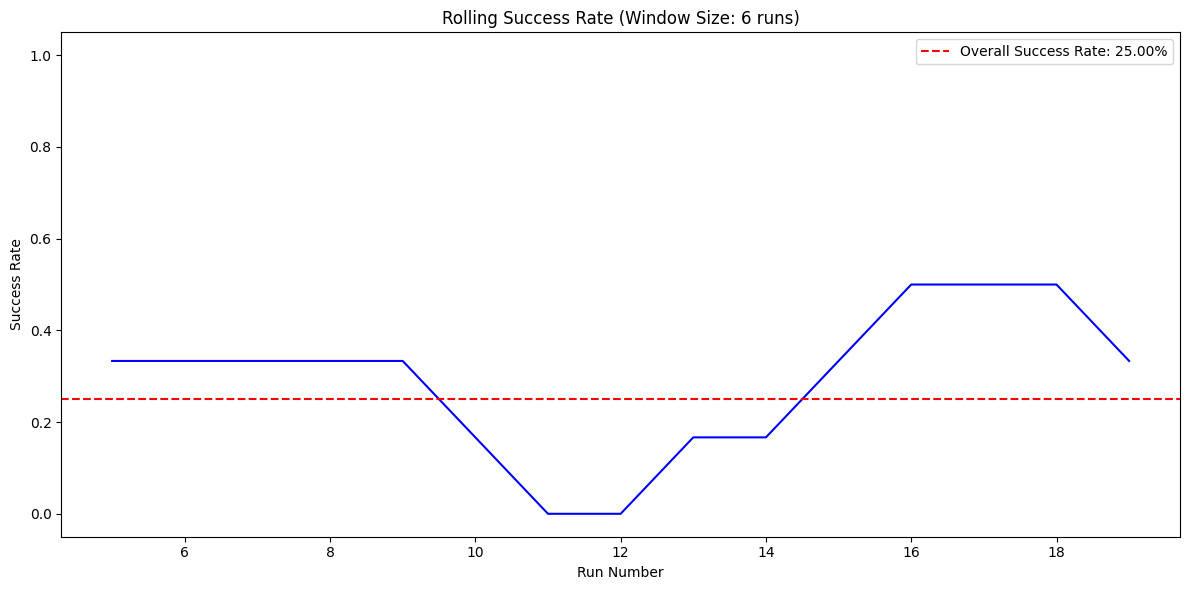

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a rolling window success rate plot
plt.figure(figsize=(12, 6))

# Convert status to binary (1 for success, 0 for error)
df["success_binary"] = (df["status"] == "success").astype(int)

# Calculate rolling success rate
window_size = 6  # adjust this value based on your data
rolling_success_rate = df["success_binary"].rolling(window=window_size).mean()

# Plot using num_run instead of start_time
plt.plot(df["num_run"], rolling_success_rate, "b-")
plt.axhline(
    y=df["success_binary"].mean(),
    color="r",
    linestyle="--",
    label=f'Overall Success Rate: {df["success_binary"].mean():.2%}',
)

plt.title(f"Rolling Success Rate (Window Size: {window_size} runs)")
plt.xlabel("Run Number")
plt.ylabel("Success Rate")
plt.ylim(-0.05, 1.05)

# Format x-axis to show integers
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: int(x)))

plt.legend()
plt.tight_layout()
plt.show()

# Success rate for the first/final n runs
 

In [36]:
# Get first 30 runs
first_30 = df.head(30)

# Calculate success rate
success_rate = (first_30["status"] == "success").mean() * 100

print(f"Success rate for first 30 runs: {success_rate:.2f}%")

# Optional: detailed breakdown
success_count = (first_30["status"] == "success").sum()
error_count = (first_30["status"] == "error").sum()
print(f"\nDetailed breakdown:")
print(f"Successes: {success_count}")
print(f"Errors: {error_count}")

Success rate for first 30 runs: 25.00%

Detailed breakdown:
Successes: 5
Errors: 15


# Test latency
 
